In [1]:
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import spVIPES

[rank: 0] Global seed set to 0
/exports/humgen/cnovellarausell/conda_envs/spVIPES_test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download a toy example

We will be using the simulated dataset generated in Figure 2 to illustrate the usage of spVIPES. The dataset is deposited in Zenodo: [zenodo link]

In [ ]:
!wget link

## Preprocessing

In [2]:
simulated_data = sc.read_h5ad("splatter_simulation.h5ad")
simulated_data.var_names_make_unique()

/exports/humgen/cnovellarausell/conda_envs/spVIPES_test/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


To apply spVIPES we first need:

- Two datasets to learn shared / private latents from
- Annotations to use for supervision

In [3]:
# In this case we define the two datasets based on the subgroup category
simulated_data.obs['Dataset'] = simulated_data.obs.Subgroup.replace(
    {'Group1': 'Dataset 1', 'Group2': 'Dataset 1', 
     'Group3': 'Dataset 2', 'Group4': 'Dataset 2'})

In [4]:
simulated_data.obs['Celltypes'] = simulated_data.obs.Group.replace(
    {'Group1': 'Cell type 1', 'Group2': 'Cell type 2', 
     'Group3': 'Cell type 3', 'Group4': 'Cell type 4', 
     'Group5': 'Cell type 5'})

To illustrate spVIPES' ability to learn private variation (i.e., variation that is not shared between groups), we use the 'Subgroup' category generated with Splatter as a ground truth. 

In [5]:
simulated_data.obs['Gene_programs'] = simulated_data.obs.Subgroup.replace(
    {'Group1': 'Gene program 1a', 'Group2': 'Gene program 2a', 
     'Group3': 'Gene program 1b', 'Group4': 'Gene program 2b'})

In [6]:
dataset1 = simulated_data[simulated_data.obs.Dataset == 'Dataset 1'].copy()
dataset2 = simulated_data[simulated_data.obs.Dataset == 'Dataset 2'].copy()

## spVIPES preprocessing and model setup

We first need the two datasets in a single AnnData object to use as input for spVIPES

In [7]:
adata = spVIPES.data.prepare_adatas({"dataset1": dataset1, "dataset2": dataset2})

Take into account that the keys you use in the dictonary will be appended to the feature names. This is needed for spVIPES' to work properly.

An spVIPES model instance requires the previously generated adata together with the group and label keys.

In [8]:
spVIPES.model.spVIPES.setup_anndata(adata, groups_key='groups', labels_key="Celltypes")

/exports/humgen/cnovellarausell/conda_envs/spVIPES_test/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
spvipes = spVIPES.model.spVIPES(adata, n_dimensions_private=7, n_dimensions_shared=10)

INFO     spVIPES: The model has been initialized                                                                   


## spVIPES training

In order to train the model we need to specify the group cell indices

In [10]:
group_indices_list = [np.where(adata.obs['groups'] == group)[0] for group in adata.obs['groups'].unique()]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
spvipes.train(group_indices_list, batch_size=128)

spVIPES inherits scvi-tools functionality like model saving or training metrics

In [ ]:
spvipes.save("spvipes_model")

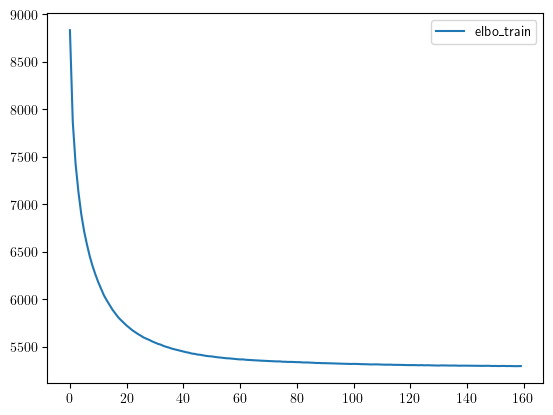

In [54]:
plt.plot(spvipes.history['elbo_train']['elbo_train'], label='elbo_train');
plt.legend()

Likewise we can also load a pretrained model

In [69]:
spvipes = spVIPES.model.spVIPES.load("spvipes_model", adata=adata)

INFO     File                                                                                                      
         /exports/humgen/cnovellarausell/DirVI/models/Experiment_9/big_simulated_experiment_True_True_10_7/model.pt
         already downloaded                                                                                        
INFO     DirVI: The model has been initialized                                                                     


In [32]:
spvipes

DirVI Model with the following params: 
n_hidden: 128, n_topics_shared: 7, n_topics_private: 6, dropout_rate: 0.1
Training status: Trained
Model's adata is minified?: False

## Latent space retrieval and visualizaton

spVIPES outputs three sets of latent variables: 

- 2 private latents for each of the datasets used as input
- 1 shared latent, representing shared variation between the groups

In [ ]:
latent = spvipes.get_latent_representation(group_indices_list, batch_size=128)

In [71]:
latent_private_dataset1 = latent['private'][0]
latent_private_dataset2 = latent['private'][1]
latent_shared = np.concatenate((latent['shared'][0], latent['shared'][1]), axis=0)

In [68]:
np.save("spvipes_shared_embedding.npy", latent_shared)
np.save("spvipes_private_embedding_dataset1.npy", latent_private_dataset1)
np.save("spvipes_private_embedding_dataset2.npy", latent_private_dataset2)

In [ ]:
adata.obsm['X_spVIPES_shared'] = latent_shared
sc.pp.neighbors(adata, use_rep="X_spVIPES_shared", key_added="spvipes_shared")
sc.tl.umap(adata, neighbors_key="spvipes_shared")
adata.obsm['X_umap_shared'] = adata.obsm['X_umap'].copy()

In [ ]:
dataset1.obsm['X_spVIPES_private'] = latent_private_dataset1
sc.pp.neighbors(dataset1, use_rep="X_spVIPES_private", key_added="spvipes_private")
sc.tl.umap(dataset1, neighbors_key="spvipes_private")
dataset1.obsm['X_umap_private'] = dataset1.obsm['X_umap'].copy()

In [ ]:
dataset2.obsm['X_spVIPES_private'] = latent_private_dataset2
sc.pp.neighbors(dataset2, use_rep="X_spVIPES_private", key_added="spvipes_private")
sc.tl.umap(dataset2, neighbors_key="spvipes_private")
dataset2.obsm['X_umap_private'] = dataset2.obsm['X_umap'].copy()

In [ ]:
palette = sns.color_palette('Accent')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
fig.tight_layout()
sc.pl.embedding(adata, basis='X_umap_shared', color=['Celltypes'], size=3, wspace=1, ax=axes[0], palette="Set2_r", show=False, title="Celltypes spVIPE shared")
sc.pl.embedding(dataset1, basis='X_umap_private', color=["Gene_programs"], size=3, wspace=1, ax=axes[1], palette=itemgetter(0,2)(palette), show=False, title="Gene programs spVIPE private dataset 1")
sc.pl.embedding(dataset2, basis='X_umap_private', color=["Gene_programs"], size=3, wspace=1, ax=axes[2], palette=itemgetter(5,7)(palette), show=False, title="Gene programs spVIPE private dataset 2")
sns.despine()
legends = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*legends)]
for ax in axes:
    ax.get_legend().remove()
fig.legend(lines, labels, bbox_to_anchor=(1., 0.55), loc="center left", borderaxespad=0, frameon=False)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sc.pl.embedding(dataset1, basis='X_umap_private', color=["Celltypes"], size=10, wspace=1, palette="Set2_r", show=False, ax=axes[0], title="Gene programs spVIPE private dataset 1")
sc.pl.embedding(dataset2, basis='X_umap_private', color=["Celltypes"], size=10, wspace=1,  palette="Set2_r", show=False, ax=axes[1], title="Gene programs spVIPE private dataset 2")
sns.despine()
legends = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*legends)]
for ax in axes:
    ax.get_legend().remove()
fig.legend(lines, labels, bbox_to_anchor=(1., 0.55), loc="center left", borderaxespad=0, frameon=False)
plt.show()

/exports/humgen/cnovellarausell/conda_envs/DirVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/exports/humgen/cnovellarausell/conda_envs/DirVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


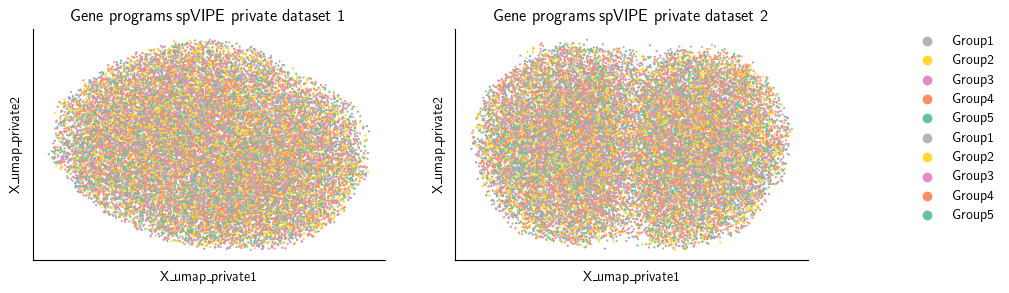

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sc.pl.embedding(dataset1, basis='X_umap_private', color=["Celltypes"], size=10, wspace=1, palette="Set2_r", show=False, ax=axes[0], title="Gene programs spVIPE private dataset 1")
sc.pl.embedding(dataset2, basis='X_umap_private', color=["Celltypes"], size=10, wspace=1,  palette="Set2_r", show=False, ax=axes[1], title="Gene programs spVIPE private dataset 2")
sns.despine()
legends = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*legends)]
for ax in axes:
    ax.get_legend().remove()
fig.legend(lines, labels, bbox_to_anchor=(1., 0.55), loc="center left", borderaxespad=0, frameon=False)